# CLASIFICADOR DE MARCAS DE COCHES: JOSÉ IGNACIO FONTECHA Y ÁLVARO OTADUY

En este trabajo, se realizará un clasificador de marcas de coches mediante empleando redes convolucionales, en un proceso iterativo en el que cada modelo intentará mejor al anterior al introducir ciertas mejoras en las redes convolucionales. En todo momento se intentará conseguir la mayor precisión posible, todo ello evitando el sobreentrenamiento, uno de los problemas principales a evitar en estos proyectos. Se comienza con un clasificador de dos tipos de marcas, para luego intentar replicar los resultados obtenidos en un clasificador de tres marcas distintas de coches. Por último, se muestran unas conclusiones y unas opciones de mejora de los modelos.

In [5]:
import keras
keras.__version__

'2.4.3'

In [6]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import shutil

from keras import layers
from keras import models
from keras import utils
from keras import regularizers, optimizers
from keras import losses
from keras import datasets

from keras.layers import LeakyReLU
from keras.layers import PReLU
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

from keras.optimizers import SGD
from keras.optimizers import RMSprop

from keras.models import Sequential
from keras.regularizers import l2

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras.callbacks import ReduceLROnPlateau

from keras_preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle

## INTRODUCCIÓN: CREACIÓN DEL DATAFRAME Y DE LAS ETIQUETAS DE LAS IMÁGENES

In [7]:
directorio_carpeta = "/Users/nachofontecha/Desktop/Máster Big Data/Análisis de Datos No Estructurados/car_images"

In [8]:
lista_coches = os.listdir(directorio_carpeta)

In [5]:
lista_coches[:5]

['Ford_Flex_2010_39_19_260_35_6_75_68_201_16_AWD_7_4_4dr_Zza.jpg',
 'Chevrolet_Suburban_2011_41_17_320_53_8_79_76_nan_15_RWD_9_4_SUV_hyG.jpg',
 'Nissan_Maxima_2011_31_18_290_35_6_73_57_190_19_FWD_5_4_4dr_Ytw.jpg',
 'Chevrolet_Silverado 1500_2014_45_20_350_53_8_80_74_nan_16_RWD_5_4_Pickup_Fhi.jpg',
 'Dodge_Durango_2019_45_20_290_36_6_75_70_201_18_AWD_6_4_SUV_usz.jpg']

In [9]:
df=pd.DataFrame()

Se crea un pandas DataFrame que se rellenará con la lista creada con las imágenes, además de crear una columna con las etiquetas de cada imágen, que coincidirá con la marca del coche.

In [10]:
df['Lista_imagenes'] = lista_coches
df['Marca'] = [imagen.split('_')[0] for imagen in lista_coches]

In [8]:
df.head(5)

,Lista_imagenes,Marca
0,Ford_Flex_2010_39_19_260_35_6_75_68_201_16_AWD...,Ford
1,Chevrolet_Suburban_2011_41_17_320_53_8_79_76_n...,Chevrolet
2,Nissan_Maxima_2011_31_18_290_35_6_73_57_190_19...,Nissan
3,Chevrolet_Silverado 1500_2014_45_20_350_53_8_8...,Chevrolet
4,Dodge_Durango_2019_45_20_290_36_6_75_70_201_18...,Dodge


In [11]:
df.groupby("Marca").count().sort_values(by = 'Lista_imagenes', ascending = False)

,Lista_imagenes
Marca,
Chevrolet,5079
Toyota,4598
Ford,4416
BMW,4121
Nissan,3881
Audi,3131
Mercedes-Benz,3097
Honda,2675
Kia,2160


## MODELO DE CLASIFICACIÓN DE DOS CLASES

In [12]:
marcas_filtradas = ['Volvo','Jeep']
df_seleccion = df.loc[df['Marca'].isin(marcas_filtradas)].reset_index().drop("index", axis = 1)

Nos quedamos con las clases seleccionadas, que son clases reconocidas y con un número satisfactorio de imágenes por marca, suficientes
para entrenar un modelo decente. Otra de las razones por la elección de estas marcas es por su similitud en el número de imágenes, para intentar conseguir que las clases estén lo más balanceadas posible.

In [13]:
df_seleccion.head()

,Lista_imagenes,Marca
0,Volvo_S90_2019_49_18_250_20_4_74_57_200_22_AWD...,Volvo
1,Jeep_Wrangler_2014_28_18_280_36_6_73_72_163_na...,Jeep
2,Volvo_XC90_2016_53_20_250_20_4_79_69_194_22_AW...,Volvo
3,Volvo_V60_2020_45_18_250_20_4_72_56_187_23_FWD...,Volvo
4,Volvo_XC90_2013_39_18_240_32_6_74_70_189_16_AW...,Volvo


In [14]:
#Se convierten las imágenes a array, normalizándolas y con un tamaño por defecto de 128x128

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255, 
                             validation_split = 0.2)

batch_size = 20 
 
train_generator = datagen.flow_from_dataframe(dataframe = df_seleccion,
                                              directory = directorio_carpeta,
                                              x_col = 'Lista_imagenes',
                                              y_col = 'Marca',
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              subset = 'training',
                                              target_size=(128, 128))


valid_generator = datagen.flow_from_dataframe(dataframe = df_seleccion,
                                              directory = directorio_carpeta,
                                              x_col = 'Lista_imagenes',
                                              y_col = 'Marca',
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              subset = 'validation',
                                              target_size=(128, 128))

## PRIMER MODELO CNN

Primero, se crea un modelo "sencillo" a partir del modelo que se encuentra en la práctica 5b realizada en clase, a partir del cual, se intentará mejorar modificando los parámetros a la hora de modificar el número de capas convolucionales, añadiéndole padding, otras funciones de activación, etc. Tras esto, se le aplicará a cada modelo un data augmentation para comparar los rendimientos del modelo sin augmentation y con augmentation.

Como se puede observar, este primer modelo cuenta con una primera capa con 32 filtros, señalándole que se trata de imágenes a color introduciéndole profundidad 3. Estos filtros tendrán tamaño de 3x3 y la función de activación será una ReLu. Tras ello, se introduce el MaxPooling, como es habitual, para reducir las dimensiones de las imágenes y eliminar información redundante. Otras dos capas convolucionales y de pooling se añaden, una de 64 filtros y otra de 128 filtros, encargadas de extrar detalles más finos de las imágenes y poder clasificarlas mejor. La última parte de trata del clasificador, con el primer paso un flatten para convertir toda la información a vector y luego una capa densa con 64 neuronas que será el clasificador en sí, teniendo como función de activación una sigmoidal.

In [16]:
clases = len(marcas_filtradas)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(clases, activation = 'sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

Se obtiene un modelo con aproximadamente 1.7 millones de parámetros, una cantidad elevada que podría suponer sobreentrenamiento. Esto se comprobará una vez se ha entrenado el modelo con la precisión del conjunto de validación. A la hora de entrenar el modelo, se introducen 50 épocas con 20 pasos por época. 

In [18]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])

In [19]:
history = model.fit(train_generator,
                     steps_per_epoch=20,
                     epochs = 50,  
                     validation_data = valid_generator)

Epoch 1/50
20/20 [==============================] - 6s 255ms/step - loss: 0.7068 - accuracy: 0.4968 - val_loss: 0.6896 - val_accuracy: 0.5072
Epoch 2/50
20/20 [==============================] - 4s 203ms/step - loss: 0.6882 - accuracy: 0.5254 - val_loss: 0.6934 - val_accuracy: 0.4907
Epoch 3/50
20/20 [==============================] - 4s 208ms/step - loss: 0.6792 - accuracy: 0.5704 - val_loss: 0.6693 - val_accuracy: 0.6186
Epoch 4/50
20/20 [==============================] - 4s 202ms/step - loss: 0.6675 - accuracy: 0.6149 - val_loss: 0.6670 - val_accuracy: 0.5918
Epoch 5/50
20/20 [==============================] - 4s 201ms/step - loss: 0.6600 - accuracy: 0.6320 - val_loss: 0.6864 - val_accuracy: 0.5093
Epoch 6/50
20/20 [==============================] - 4s 201ms/step - loss: 0.6488 - accuracy: 0.6229 - val_loss: 0.6273 - val_accuracy: 0.6825
Epoch 7/50
20/20 [==============================] - 4s 195ms/step - loss: 0.6204 - accuracy: 0.6844 - val_loss: 0.6327 - val_accuracy: 0.6309
Epoch 

In [20]:
model.save('model_1.h5')

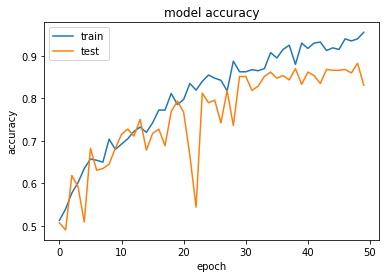

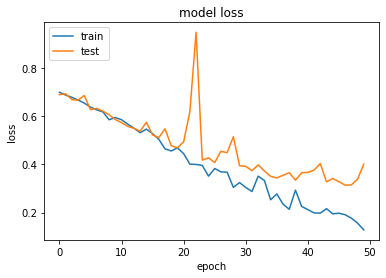

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Como se había deducido anteriormente, el alto número de parámetros ha provocado un cierto sobreentrenamiento, como vemos en los valores medios de la accuracy en entrenamiento y validación del modelo a partir en las ultimas épocas, ya que es el punto donde las gráficas de entrenamiento y validación se separan de forma notable. Esto se intentará solucionar con los modelos siguientes, en los que se le introducirá cambios en las capas convolucionales.

Una de las posibilidades de mejora del modelo es el introducir data augmentation, ya que con esto conseguimos que 'aumente' de forma artificial el número de imágenes en el conjunto de entrenamiento, y así conseguir controlar el sobreentrenamiento. Los parámetros del data augmentation se muestran a continuación, donde se controla especialemte el parámetro de ángulo de rotación de las fotos, ya que si es muy elevado, podría confundir entre clases o incluso pensar que no es un coche.

In [12]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2,
    fill_mode = 'nearest')

In [23]:
train_generator2 = train_datagen.flow_from_dataframe(dataframe = df_seleccion,
                                                    directory = directorio_carpeta,
                                                    x_col = 'Lista_imagenes',
                                                    y_col = 'Marca',
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    subset = 'training',
                                                    target_size = (128, 128))

valid_generator2 = datagen.flow_from_dataframe(dataframe = df_seleccion,
                                              directory = directorio_carpeta,
                                              x_col = 'Lista_imagenes',
                                              y_col = 'Marca',
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              subset = 'validation',
                                              target_size = (128, 128))

Found 1942 validated image filenames belonging to 2 classes.
Found 485 validated image filenames belonging to 2 classes.


In [24]:
clases = len(marcas_filtradas)

modelB = models.Sequential()
modelB.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3)))
modelB.add(layers.MaxPooling2D((2, 2)))
modelB.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelB.add(layers.MaxPooling2D((2, 2)))
modelB.add(layers.Conv2D(128, (3, 3), activation='relu'))
modelB.add(layers.MaxPooling2D((2, 2)))
modelB.add(layers.Flatten())
modelB.add(layers.Dense(64, activation='relu'))
modelB.add(Dense(clases, activation = 'sigmoid'))

In [25]:
modelB.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])

In [26]:
history2 = modelB.fit(train_generator2,
                     steps_per_epoch=20,
                     epochs = 50,  
                     validation_data = valid_generator2)

Epoch 1/50
20/20 [==============================] - 5s 219ms/step - loss: 0.7521 - accuracy: 0.5005 - val_loss: 0.6952 - val_accuracy: 0.5093
Epoch 2/50
20/20 [==============================] - 4s 216ms/step - loss: 0.6997 - accuracy: 0.4641 - val_loss: 0.7011 - val_accuracy: 0.5093
Epoch 3/50
20/20 [==============================] - 4s 213ms/step - loss: 0.7093 - accuracy: 0.4572 - val_loss: 0.6891 - val_accuracy: 0.5093
Epoch 4/50
20/20 [==============================] - 4s 213ms/step - loss: 0.6849 - accuracy: 0.5469 - val_loss: 0.6859 - val_accuracy: 0.5464
Epoch 5/50
20/20 [==============================] - 4s 210ms/step - loss: 0.6880 - accuracy: 0.5631 - val_loss: 0.6843 - val_accuracy: 0.6309
Epoch 6/50
20/20 [==============================] - 4s 209ms/step - loss: 0.6836 - accuracy: 0.5776 - val_loss: 0.6832 - val_accuracy: 0.5299
Epoch 7/50
20/20 [==============================] - 4s 212ms/step - loss: 0.6880 - accuracy: 0.5473 - val_loss: 0.6779 - val_accuracy: 0.5443
Epoch 

In [27]:
modelB.save('model_2.h5')

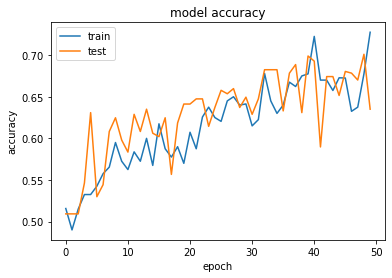

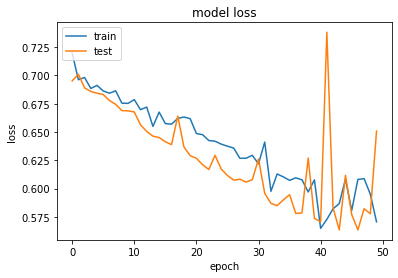

In [28]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Con este nuevo modelo con data augmentation, conseguimos controlar el sobreentrenamiento, acabando con él por completo (salvo un ligero sobreentrenamiento en la época final). Por contra, la precisión del modelo ha descendido de forma notable, como se observa en las gráficas de precisión. Aun teniéndo esa pérdida de precisión, este segundo modelo podría considerarse mejor que el primero debido a la ausencia de sobreentrenamiento, pero debido a que el sobreentrenamiento del primer modelo no es excesivo y tiene una precisión mucho mayor, se elegiría éste como el ideal, pero esto queda a elección del consumidor.

## SEGUNDO MODELO CNN

Para este segundo modelo, se le introduce una capa densa nueva en el clasificador con función de activación softmax que cuenta con un buen comportamiento en las capas del clasificador. Además, también se le introduce una probabilidad de dropout de 0.1 tras las capas de pooling.

In [32]:
modelC = models.Sequential()
modelC.add(layers.Conv2D(32, (3, 3),activation='relu',
                        input_shape=(128, 128, 3)))
modelC.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

modelC.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelC.add(layers.MaxPooling2D((2, 2)))
modelC.add(Dropout(0.1))

modelC.add(layers.Conv2D(128, (3, 3), activation='relu'))
modelC.add(layers.MaxPooling2D((2, 2)))
modelC.add(Dropout(0.1))

modelC.add(layers.Flatten())
modelC.add(layers.Dense(64, activation='softmax'))
modelC.add(layers.Dense(32, activation='relu'))
modelC.add(Dense(clases, activation = 'sigmoid'))

In [33]:
modelC.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 128)      

Para este modelo, el número de parámetros ha aumentado ligeramente como se puede observar.

In [34]:
modelC.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])

In [36]:
history3 = modelC.fit(train_generator,
                     steps_per_epoch=20,
                     epochs = 50,  
                     validation_data = valid_generator)

Epoch 1/50
20/20 [==============================] - 5s 217ms/step - loss: 0.6946 - accuracy: 0.4866 - val_loss: 0.6932 - val_accuracy: 0.4907
Epoch 2/50
20/20 [==============================] - 4s 218ms/step - loss: 0.6913 - accuracy: 0.5262 - val_loss: 0.6920 - val_accuracy: 0.4907
Epoch 3/50
20/20 [==============================] - 4s 212ms/step - loss: 0.6863 - accuracy: 0.5615 - val_loss: 0.6885 - val_accuracy: 0.5629
Epoch 4/50
20/20 [==============================] - 4s 205ms/step - loss: 0.6827 - accuracy: 0.6022 - val_loss: 0.6862 - val_accuracy: 0.5856
Epoch 5/50
20/20 [==============================] - 4s 206ms/step - loss: 0.6767 - accuracy: 0.6043 - val_loss: 0.6804 - val_accuracy: 0.5959
Epoch 6/50
20/20 [==============================] - 4s 214ms/step - loss: 0.6743 - accuracy: 0.5973 - val_loss: 0.6837 - val_accuracy: 0.5773
Epoch 7/50
20/20 [==============================] - 4s 214ms/step - loss: 0.6747 - accuracy: 0.6242 - val_loss: 0.6781 - val_accuracy: 0.6021
Epoch 

In [37]:
modelC.save('model_3.h5')

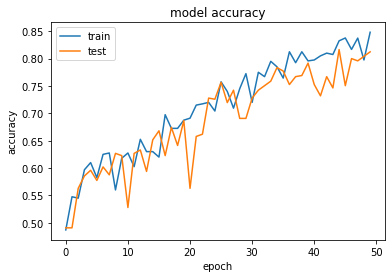

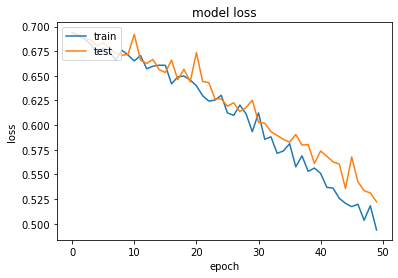

In [38]:
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

La precisión de este modelo ha disminuido con respecto al primer modelo, pero se consigue limitar el sobreentrenamiento del modelo sin meterle incluso data augmentation. Este podría significar un buen paso en la consecución del modelo ideal, ya que el sobreentrenamiento ha desaparecido prácticamente, siendo ahora el principal objetivo el aumento de precisión. También se prueba para este modelo la introducción de data augmentation, pero viendo los resultados del modelo anterior, se puede deducir que la precisión disminuirá.

In [39]:
modelD = models.Sequential()
modelD.add(layers.Conv2D(32, (3, 3),activation='relu',
                        input_shape=(128, 128, 3)))
modelD.add(layers.MaxPooling2D((2, 2)))
modelD.add(Dropout(0.1))

modelD.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelD.add(layers.MaxPooling2D((2, 2)))
modelD.add(Dropout(0.1))

modelD.add(layers.Conv2D(128, (3, 3), activation='relu'))
modelD.add(layers.MaxPooling2D((2, 2)))
modelD.add(Dropout(0.1))

modelD.add(layers.Flatten())
modelD.add(layers.Dense(64, activation='softmax'))
modelD.add(layers.Dense(32, activation='relu'))
modelD.add(Dense(clases, activation = 'sigmoid'))

In [40]:
modelD.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])

In [41]:
history4 = modelD.fit(train_generator2,
                     steps_per_epoch=20,
                     epochs = 50,  
                     validation_data = valid_generator2)

Epoch 1/50
20/20 [==============================] - 5s 231ms/step - loss: 0.6941 - accuracy: 0.4685 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 2/50
20/20 [==============================] - 4s 222ms/step - loss: 0.6933 - accuracy: 0.5428 - val_loss: 0.6941 - val_accuracy: 0.4907
Epoch 3/50
20/20 [==============================] - 4s 222ms/step - loss: 0.6875 - accuracy: 0.5791 - val_loss: 0.6960 - val_accuracy: 0.4907
Epoch 4/50
20/20 [==============================] - 4s 221ms/step - loss: 0.6944 - accuracy: 0.4921 - val_loss: 0.6931 - val_accuracy: 0.4907
Epoch 5/50
20/20 [==============================] - 4s 220ms/step - loss: 0.6914 - accuracy: 0.5037 - val_loss: 0.6942 - val_accuracy: 0.4907
Epoch 6/50
20/20 [==============================] - 5s 227ms/step - loss: 0.6943 - accuracy: 0.4782 - val_loss: 0.6937 - val_accuracy: 0.4907
Epoch 7/50
20/20 [==============================] - 4s 216ms/step - loss: 0.6927 - accuracy: 0.5021 - val_loss: 0.6960 - val_accuracy: 0.4907
Epoch 

In [42]:
modelD.save('model_4.h5')

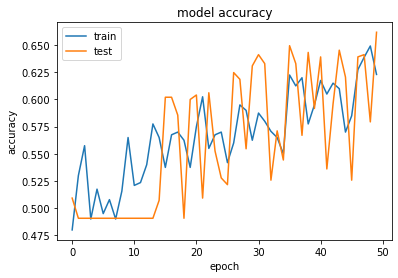

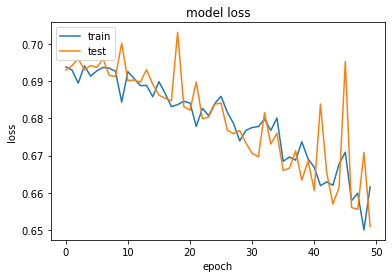

In [43]:
# summarize history for accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Como se había deducido, la precisión del modelo con data augmentation disminuye de forma notable respecto al modelo sin ella. Por contra, con ella se consigue controlar el pequeño sobreentrenamiento que había surgido en las últimas épocas, pero al ser tan pequeño, el introducir data augmentation queda descartado para el siguiente modelo.

## TERCER MODELO DNN

En el tercer modelo, se modificará el tamaño de las imágenes de 128x128 a 256x256, buscando aumentar los parámetros. Se prueba también a añadirle padding a todas las capas convolucionales. Una de las características principales de este nuevo modelo es el cambio del número de neuronas de la primera capa del clasificador, de 64 a 128 neuronas. Esto conlleva un aumento del número de parámetros y de los tiempos de ejecución.

In [44]:
train_generator3 = datagen.flow_from_dataframe(dataframe = df_seleccion,
                                              directory = directorio_carpeta,
                                              x_col = 'Lista_imagenes',
                                              y_col = 'Marca',
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              subset = 'training',
                                              target_size=(256,256))


valid_generator3 = datagen.flow_from_dataframe(dataframe = df_seleccion,
                                              directory = directorio_carpeta,
                                              x_col = 'Lista_imagenes',
                                              y_col = 'Marca',
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              subset = 'validation',
                                              target_size=(256, 256))

Found 1942 validated image filenames belonging to 2 classes.
Found 485 validated image filenames belonging to 2 classes.


In [53]:
modelE = models.Sequential()
modelE.add(layers.Conv2D(32, (3, 3),padding = 'same',activation='relu',
                        input_shape=(256, 256, 3)))
modelE.add(layers.MaxPooling2D((2, 2)))
modelE.add(Dropout(0.2))

modelE.add(layers.Conv2D(64, (3, 3),padding= 'same', activation='relu'))
modelE.add(layers.MaxPooling2D((2, 2)))
modelE.add(Dropout(0.2))

modelE.add(layers.Conv2D(128, (3, 3), padding= 'same', activation='relu'))
modelE.add(layers.MaxPooling2D((2, 2)))
modelE.add(Dropout(0.2))

modelE.add(layers.Flatten())
modelE.add(layers.Dense(128, activation='softmax'))
modelE.add(layers.Dense(32, activation='relu'))
modelE.add(Dense(clases, activation = 'softmax'))

In [54]:
modelE.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])

In [55]:
modelE.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 128)      

In [56]:
history5 = modelE.fit(train_generator3,
                     steps_per_epoch=20,
                     epochs = 50,  
                     validation_data = valid_generator3)

Epoch 1/50
20/20 [==============================] - 19s 928ms/step - loss: 0.6967 - accuracy: 0.4551 - val_loss: 0.6934 - val_accuracy: 0.4845
Epoch 2/50
20/20 [==============================] - 18s 921ms/step - loss: 0.6939 - accuracy: 0.5314 - val_loss: 0.6936 - val_accuracy: 0.4907
Epoch 3/50
20/20 [==============================] - 18s 924ms/step - loss: 0.6932 - accuracy: 0.5265 - val_loss: 0.6931 - val_accuracy: 0.4907
Epoch 4/50
20/20 [==============================] - 18s 928ms/step - loss: 0.6916 - accuracy: 0.5326 - val_loss: 0.6927 - val_accuracy: 0.5258
Epoch 5/50
20/20 [==============================] - 18s 900ms/step - loss: 0.6908 - accuracy: 0.5073 - val_loss: 0.6929 - val_accuracy: 0.4907
Epoch 6/50
20/20 [==============================] - 18s 921ms/step - loss: 0.6912 - accuracy: 0.5277 - val_loss: 0.6899 - val_accuracy: 0.5567
Epoch 7/50
20/20 [==============================] - 18s 924ms/step - loss: 0.6977 - accuracy: 0.4992 - val_loss: 0.6936 - val_accuracy: 0.4907

In [57]:
modelE.save('model_5.h5')

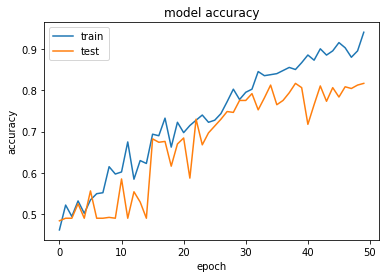

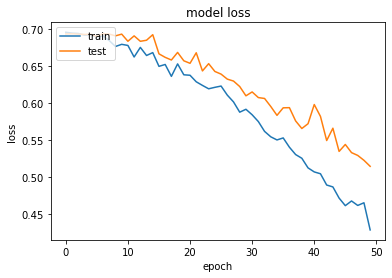

In [58]:
# summarize history for accuracy
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

En este caso, se observa un aumento de la precisión respecto al modelo anterior, pero el sobreentrenamiento ha empeorado, por lo que aquí sería una buena práctica introducir data augmentation para controlar esto. El data augmentation implica también una reducción de la precisión como se ha visto en los ejemplos anteriores, pero como se ha comentado al principio, se busca la mayor precisión sin sobreentrenamiento.

## MODELO DE CLASIFICACIÓN DE TRES CLASES

Se emplean estas tres marcas de coches porque cuentan con un número similar de imágenes, para que no queden muy desbalanceadas entre ellas.

In [13]:
marcas_filtradas = ['Alfa Romeo','Rolls-Royce','Lamborghini']
df_seleccion2 = df.loc[df['Marca'].isin(marcas_filtradas)].reset_index().drop("index", axis = 1)

In [14]:
df_seleccion2

,Lista_imagenes,Marca
0,Alfa Romeo_4C Spider_2020_67_17_230_17_4_73_46...,Alfa Romeo
1,Alfa Romeo_Stelvio_2020_43_18_280_20_4_74_66_1...,Alfa Romeo
2,Rolls-Royce_Ghost_2012_246_19_560_66_12_76_61_...,Rolls-Royce
3,Lamborghini_Huracan_2016_262_20_600_52_10_75_4...,Lamborghini
4,Lamborghini_Aventador_2019_417_20_720_65_12_79...,Lamborghini
...,...,...
813,Alfa Romeo_Stelvio_2020_43_18_280_20_4_74_66_1...,Alfa Romeo
814,Alfa Romeo_4C_2019_nan_nan_nan_nan_nan_nan_nan...,Alfa Romeo
815,Alfa Romeo_Stelvio_2020_43_18_280_20_4_74_66_1...,Alfa Romeo
816,Alfa Romeo_Giulia_2017_39_17_280_20_4_73_56_18...,Alfa Romeo


In [15]:
df_seleccion2['Marca_cat']=[1 if marca=='Alfa Romeo' else 2 if marca=='Rolls-Royce' else 3 for marca in df_seleccion2['Marca']]

In [62]:
df_seleccion2.head(10)

,Lista_imagenes,Marca,Marca_cat
0,Alfa Romeo_4C Spider_2020_67_17_230_17_4_73_46...,Alfa Romeo,1
1,Alfa Romeo_Stelvio_2020_43_18_280_20_4_74_66_1...,Alfa Romeo,1
2,Rolls-Royce_Ghost_2012_246_19_560_66_12_76_61_...,Rolls-Royce,2
3,Lamborghini_Huracan_2016_262_20_600_52_10_75_4...,Lamborghini,3
4,Lamborghini_Aventador_2019_417_20_720_65_12_79...,Lamborghini,3
5,Alfa Romeo_Stelvio_2020_43_18_280_20_4_74_66_1...,Alfa Romeo,1
6,Rolls-Royce_Phantom_2011_380_21_450_67_12_78_6...,Rolls-Royce,2
7,Lamborghini_Huracan_2016_262_20_600_52_10_75_4...,Lamborghini,3
8,Alfa Romeo_Stelvio_2020_43_18_280_20_4_74_66_1...,Alfa Romeo,1
9,Alfa Romeo_Giulia_2020_41_17_280_20_4_73_56_18...,Alfa Romeo,1


## TERCER MODELO CNN PARA TRES CLASES

Se emplea el mismo modelo que con el clasificador de dos clases, pero en este caso para las tres clases, por lo que se modifica el train generator.

In [63]:
train_generator3 = datagen.flow_from_dataframe(dataframe = df_seleccion2,
                                              directory = directorio_carpeta,
                                              x_col = 'Lista_imagenes',
                                              y_col = 'Marca',
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              subset = 'training',
                                              target_size=(256,256))


valid_generator3 = datagen.flow_from_dataframe(dataframe = df_seleccion2,
                                              directory = directorio_carpeta,
                                              x_col = 'Lista_imagenes',
                                              y_col = 'Marca',
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              subset = 'validation',
                                              target_size=(256, 256))

Found 655 validated image filenames belonging to 3 classes.
Found 163 validated image filenames belonging to 3 classes.


In [68]:
#clases=len(df_seleccion2['Marca'])

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),padding = 'same',activation='relu',
                        input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3),padding= 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), padding= 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='softmax'))
model.add(layers.Dense(32, activation='relu'))
model.add(Dense(3, activation = 'softmax'))

In [69]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 128)      

In [70]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])

In [71]:
history6 = model.fit(train_generator3,
                     steps_per_epoch=20,
                     epochs = 50,  
                     validation_data = valid_generator3)

Epoch 1/50
20/20 [==============================] - 16s 792ms/step - loss: 1.0977 - accuracy: 0.3447 - val_loss: 1.0933 - val_accuracy: 0.3681
Epoch 2/50
20/20 [==============================] - 16s 779ms/step - loss: 1.0961 - accuracy: 0.3558 - val_loss: 1.0972 - val_accuracy: 0.3681
Epoch 3/50
20/20 [==============================] - 16s 795ms/step - loss: 1.0976 - accuracy: 0.3547 - val_loss: 1.0948 - val_accuracy: 0.5092
Epoch 4/50
20/20 [==============================] - 16s 817ms/step - loss: 1.0897 - accuracy: 0.4696 - val_loss: 1.0863 - val_accuracy: 0.5031
Epoch 5/50
20/20 [==============================] - 16s 807ms/step - loss: 1.0759 - accuracy: 0.5037 - val_loss: 1.0827 - val_accuracy: 0.5031
Epoch 6/50
20/20 [==============================] - 16s 814ms/step - loss: 1.0740 - accuracy: 0.5014 - val_loss: 1.0795 - val_accuracy: 0.4847
Epoch 7/50
20/20 [==============================] - 16s 797ms/step - loss: 1.0824 - accuracy: 0.4314 - val_loss: 1.0747 - val_accuracy: 0.4908

In [72]:
model.save('model_6.h5')

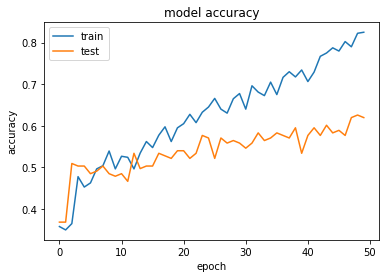

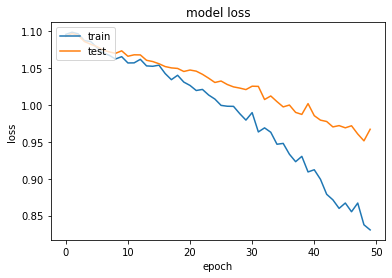

In [73]:
# summarize history for accuracy
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

El sobreentrenamiento encontrado en este modelo es muy notable, mucho mayor que para los modelos de clasificación de dos clases. Esto puede deberse al escaso número de imágenes que se dispone para ambos conjuntos. En este caso, se vuelve necesario introducir data augmentation para controlar esto.

In [78]:
modelA = models.Sequential()
modelA.add(layers.Conv2D(32, (3, 3),padding = 'same',activation='relu',
                        input_shape=(256, 256, 3)))
modelA.add(layers.MaxPooling2D((2, 2)))
modelA.add(Dropout(0.2))

modelA.add(layers.Conv2D(64, (3, 3),padding= 'same', activation='relu'))
modelA.add(layers.MaxPooling2D((2, 2)))
modelA.add(Dropout(0.2))

modelA.add(layers.Conv2D(128, (3, 3), padding= 'same', activation='relu'))
modelA.add(layers.MaxPooling2D((2, 2)))
modelA.add(Dropout(0.2))

modelA.add(layers.Flatten())
modelA.add(layers.Dense(64, activation='softmax'))
modelA.add(layers.Dense(32, activation='relu'))
modelA.add(Dense(3, activation = 'softmax'))

In [79]:
modelA.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])

In [18]:
#batch_size=20
train_generator4 = train_datagen.flow_from_dataframe(dataframe = df_seleccion2,
                                                    directory = directorio_carpeta,
                                                    x_col = 'Lista_imagenes',
                                                    y_col = 'Marca',
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    subset = 'training',
                                                    target_size = (256, 256))

valid_generator4 = train_datagen.flow_from_dataframe(dataframe = df_seleccion2,
                                              directory = directorio_carpeta,
                                              x_col = 'Lista_imagenes',
                                              y_col = 'Marca',
                                              class_mode = 'categorical',
                                              batch_size = batch_size,
                                              subset = 'validation',
                                              target_size = (256, 256))

Found 655 validated image filenames belonging to 3 classes.
Found 163 validated image filenames belonging to 3 classes.


In [81]:
history7 = modelA.fit(train_generator4,
                     steps_per_epoch=20,
                     epochs = 50,  
                     validation_data = valid_generator4)

Epoch 1/50
20/20 [==============================] - 17s 796ms/step - loss: 1.1019 - accuracy: 0.3225 - val_loss: 1.1007 - val_accuracy: 0.2638
Epoch 2/50
20/20 [==============================] - 15s 766ms/step - loss: 1.0981 - accuracy: 0.2971 - val_loss: 1.0961 - val_accuracy: 0.3681
Epoch 3/50
20/20 [==============================] - 16s 781ms/step - loss: 1.0983 - accuracy: 0.3492 - val_loss: 1.0953 - val_accuracy: 0.3681
Epoch 4/50
20/20 [==============================] - 16s 801ms/step - loss: 1.0983 - accuracy: 0.3446 - val_loss: 1.0937 - val_accuracy: 0.4663
Epoch 5/50
20/20 [==============================] - 16s 800ms/step - loss: 1.0948 - accuracy: 0.3777 - val_loss: 1.0922 - val_accuracy: 0.4908
Epoch 6/50
20/20 [==============================] - 16s 789ms/step - loss: 1.0833 - accuracy: 0.4578 - val_loss: 1.0849 - val_accuracy: 0.4724
Epoch 7/50
20/20 [==============================] - 16s 779ms/step - loss: 1.0801 - accuracy: 0.4607 - val_loss: 1.0788 - val_accuracy: 0.4969

In [82]:
modelA.save('model_7.h5')

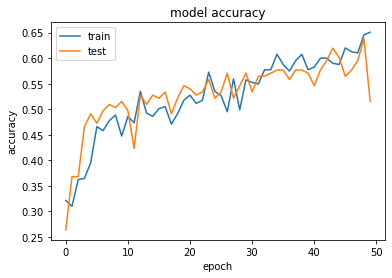

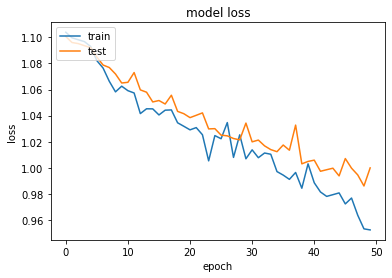

In [83]:
# summarize history for accuracy
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Siguiendo el comportamiento de modelos anteriores, el sobreentrenamiento se ha controlado con el data augmentation, pero se ha penalizado la precisión. 

Tras haber realizado el estudio de los modelos de clasificación para dos y tres clases, se llega a la conclusión que la introducción de nuevas capas en la red no siempre significa una mejoría del modelo. Se aumentará la precisión sí, pero a costa del sobreentrenamiento, ya que aumenta de forma notable el número de parámetros de la red, y para el número de imágenes que se manejan en esta práctica no es ideal tener un excesivo número de parámetros. Lo ideal sería ir introduciendo data augmentation e ir tocando las funciones de activación de las neuronas de las capas, además de modificar la posibilidad de dropout de las neuronas, o incluso cambiando el tipo de las capas convolucionales a Separable Conv2D, que acelera la convergencia del modelo. El número de épocas seleccionado se podría aumentar, siendo esto un punto interesante de mejora en el último modelo, ya que muestra posibilidades de mejora si se le aumentan las épocas.

Una de las vías de mejora del modelo sería con transfer learning, empleando modelos ya entrenados con un gran número de imágenes como puede ser ResNet50. Esto es lo que se muestra a continuación, con el modelo ResNet50 con todas las capas congeladas excepto las del clasificador.

In [4]:
from keras.applications.resnet50 import ResNet50


modelo = ResNet50(weights = 'imagenet',
                     include_top = False, 
                     input_shape = (256, 256, 3))

In [25]:
model1 = models.Sequential()

model1.add(modelo)
model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation = 'relu'))
model1.add(layers.Dense(3, activation = 'softmax'))

In [26]:
model1.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics = ['accuracy'])

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Se introduce Early Stopping ya que se trata de un modelo muy extenso y podría quedarse entrenando mucho tiempo.

In [27]:
history8 = model1.fit(
      train_generator4,
      steps_per_epoch=20,
      epochs=50,
      validation_data=valid_generator4,
      validation_steps=6,
      verbose=1,callbacks=[es, mc])

Epoch 1/50
20/20 [==============================] - 115s 5s/step - loss: 6.0178 - accuracy: 0.4431 - val_loss: 35.7658 - val_accuracy: 0.3167

Epoch 00001: val_accuracy improved from -inf to 0.31667, saving model to best_model.h5
Epoch 2/50
20/20 [==============================] - 104s 5s/step - loss: 0.6750 - accuracy: 0.7612 - val_loss: 6.2402 - val_accuracy: 0.2833

Epoch 00002: val_accuracy did not improve from 0.31667
Epoch 3/50
 2/20 [==>...........................] - ETA: 1:29 - loss: 0.8118 - accuracy: 0.6875

KeyboardInterrupt: 

Se para el modelo por la integridad del ordenador. Se puede observar el gran salto de la función de pérdida de la primera época a la segunda, lo que indica que entrenando el modelo de forma completa, se conseguirían resultados muy satisfactorios.